In [102]:
pip install -U kaleido

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 4.9 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [16]:
import os
from scipy.stats import pearsonr
import plotly.express as px
try:
    import import_ipynb
except :
    !pip install import_ipynb
    import import_ipynb
import Predistim_Library as pl
import nibabel as nib
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import laBIBILaRORO as lbr

In [4]:
region_mapping = {
    "GP_e_L": 3,
    "GP_i_L": 4,
    "GP_i_R": 104,
    "GP_e_R": 103
}

In [5]:
import os
np.set_printoptions(precision=3)
df1 = pd.read_excel(os.path.join(pl.STUDY_PATH,"csv_xlsx",'Analyse_Imagerie_Predistim_V4_20210208.xlsx'),engine='openpyxl',index_col=0)
df1.rename(columns={'MoCA_TOT _V0':'MoCA_TOT_V0'},inplace=True)
df1=df1.loc[:,~df1.columns.str.startswith('R2_')]

Crée un masque des voxels dont l'intensité R2* depasse la mediane+2 IQR de la structure
Récupère :
    volume de la strcuture 
    volume du masque
    le R2* median de la structure
    l'IQR du R2* de la structure
    le QSM mpyen du masque


In [ ]:
def calculate_region_mean_QSM_above_threshold(subject_name):
    # Définir les chemins des fichiers pour le sujet donné
    image_paths = [
        f"/NAS/deathrow/protocoles/predistim/QSM/{subject_name}/QSM_lin_3DT1.nii.gz",
        f"/NAS/deathrow/protocoles/predistim/R2/{subject_name}/R2_lin_3DT1.nii.gz",
        f"/NAS/deathrow/protocoles/predistim/3DT1/{subject_name}/combined_{subject_name}_on3DT1.nii.gz"
    ]
    
    # Charger les images
    image_QSM = nib.load(image_paths[0]).get_fdata()
    image_R2s = nib.load(image_paths[1]).get_fdata()
    image_struct = nib.load(image_paths[2]).get_fdata()
    
    # Calculer les valeurs de region_mean_QSM_above_threshold
    region_mean_QSM_above_threshold = {}
    for region, value in region_mapping.items():
        # Créer un masque pour la région
        region_mask = (image_struct == value)
        
        # Créer un masque pour les voxels de R2s qui dépassent la médiane + 2 IQR
        region_values_R2s = image_R2s[region_mask]
        median_R2s = np.median(region_values_R2s)
        iqr_R2s = np.percentile(region_values_R2s, 75) - np.percentile(region_values_R2s, 25)
        threshold_R2s = median_R2s + 2 * iqr_R2s
        mask_above_threshold_R2s = (image_R2s > threshold_R2s) & region_mask
        
        # Calculer les volumes en termes de nombre de pixels pour les masques
        region_mean_QSM_above_threshold[f"{region}_volume_total"] = region_mask.sum()
        region_mean_QSM_above_threshold[f"{region}_volume_above_threshold"] = mask_above_threshold_R2s.sum()
        
        # Calculer la médiane et l'IQR des valeurs de R2s pour cette région
        region_mean_QSM_above_threshold[f"{region}_r2s_median"] = median_R2s
        region_mean_QSM_above_threshold[f"{region}_r2s_iqr"] = iqr_R2s

        
        # Calculer la moyenne des valeurs de QSM pour ce masque
        region_values_QSM = image_QSM[mask_above_threshold_R2s]
        region_mean_QSM_above_threshold[f"{region}_qsm_moyen"] = region_values_QSM.mean()
    
    return region_mean_QSM_above_threshold

In [23]:
import os
import glob

qsm_files = glob.glob("/NAS/deathrow/protocoles/predistim/QSM/*/QSM_lin_3DT1.nii.gz")
results = []
for qsm_file in qsm_files:
    subj = os.path.basename(os.path.dirname(qsm_file))
    struct_file = f"/NAS/deathrow/protocoles/predistim/3DT1/{subj}/combined_{subj}_on3DT1.nii.gz"
    if os.path.isfile(struct_file):
        vals=calculate_region_mean_QSM_above_threshold(subj)
        print(f"Valeurs pour le sujet {subj}: {vals}")
        results.append({'Subject': subj, **vals})

df_results = pd.DataFrame(results)

Valeurs pour le sujet 01023CF: {'GP_e_L_volume_total': 904, 'GP_e_L_volume_above_threshold': 94, 'GP_e_L_r2s_median': 42.49412626290869, 'GP_e_L_r2s_iqr': 11.59834919317015, 'GP_e_L_qsm_moyen': -0.057395131177890156, 'GP_i_L_volume_total': 384, 'GP_i_L_volume_above_threshold': 9, 'GP_i_L_r2s_median': 39.0909884440078, 'GP_i_L_r2s_iqr': 6.247041912973124, 'GP_i_L_qsm_moyen': -0.03528075667036487, 'GP_i_R_volume_total': 403, 'GP_i_R_volume_above_threshold': 1, 'GP_i_R_r2s_median': 36.632852771516596, 'GP_i_R_r2s_iqr': 13.258900229856643, 'GP_i_R_qsm_moyen': -0.061202539467598696, 'GP_e_R_volume_total': 969, 'GP_e_R_volume_above_threshold': 67, 'GP_e_R_r2s_median': 42.25585015708435, 'GP_e_R_r2s_iqr': 18.075214648125026, 'GP_e_R_qsm_moyen': -0.06550574405376584}
Valeurs pour le sujet 06004CS: {'GP_e_L_volume_total': 835, 'GP_e_L_volume_above_threshold': 8, 'GP_e_L_r2s_median': 43.238610449392766, 'GP_e_L_r2s_iqr': 19.828959123716217, 'GP_e_L_qsm_moyen': -0.08130734458403023, 'GP_i_L_volum

/tmp/ipykernel_1147218/3614719117.py:38: RuntimeWarning: Mean of empty slice.
  region_mean_QSM_above_threshold[f"{region}_qsm_moyen"] = region_values_QSM.mean()
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Valeurs pour le sujet 06011SB: {'GP_e_L_volume_total': 816, 'GP_e_L_volume_above_threshold': 31, 'GP_e_L_r2s_median': 36.6358484466677, 'GP_e_L_r2s_iqr': 7.585199667236118, 'GP_e_L_qsm_moyen': -0.05023684308668558, 'GP_i_L_volume_total': 361, 'GP_i_L_volume_above_threshold': 1, 'GP_i_L_r2s_median': 33.19121623250918, 'GP_i_L_r2s_iqr': 7.4925445428956685, 'GP_i_L_qsm_moyen': -0.014114769978717832, 'GP_i_R_volume_total': 350, 'GP_i_R_volume_above_threshold': 0, 'GP_i_R_r2s_median': 33.892485732834466, 'GP_i_R_r2s_iqr': 5.812202947751288, 'GP_i_R_qsm_moyen': nan, 'GP_e_R_volume_total': 807, 'GP_e_R_volume_above_threshold': 38, 'GP_e_R_r2s_median': 37.691909607168085, 'GP_e_R_r2s_iqr': 6.460473166554877, 'GP_e_R_qsm_moyen': -0.028089527246666444}
Valeurs pour le sujet 06032BM: {'GP_e_L_volume_total': 1439, 'GP_e_L_volume_above_threshold': 161, 'GP_e_L_r2s_median': 32.01955537969197, 'GP_e_L_r2s_iqr': 6.773415624724059, 'GP_e_L_qsm_moyen': -0.08525746552982949, 'GP_i_L_volume_total': 655, '

In [ ]:
df_results = pd.DataFrame(results)
df_results.index=df_results['Subject']

In [44]:
df_results.to_csv('/NAS/deathrow/protocoles/predistim/QSM/region_mean_QSM_above_threshold.csv', index=False)

In [6]:
df_results = pd.read_csv('/NAS/deathrow/protocoles/predistim/QSM/region_mean_QSM_above_threshold.csv')
df_results.index=df_results['Subject']
df_results.describe()

,GP_e_L_volume_total,GP_e_L_volume_above_threshold,GP_e_L_r2s_median,GP_e_L_r2s_iqr,GP_e_L_qsm_moyen,GP_i_L_volume_total,GP_i_L_volume_above_threshold,GP_i_L_r2s_median,GP_i_L_r2s_iqr,GP_i_L_qsm_moyen,GP_i_R_volume_total,GP_i_R_volume_above_threshold,GP_i_R_r2s_median,GP_i_R_r2s_iqr,GP_i_R_qsm_moyen,GP_e_R_volume_total,GP_e_R_volume_above_threshold,GP_e_R_r2s_median,GP_e_R_r2s_iqr,GP_e_R_qsm_moyen
count,297.000000,297.000000,297.000000,297.000000,281.000000,297.000000,297.000000,297.000000,297.000000,214.000000,297.000000,297.000000,297.000000,297.000000,221.000000,297.000000,297.000000,297.000000,297.000000,277.000000
mean,893.114478,40.676768,37.942262,11.262146,-0.064724,404.269360,9.622896,34.522899,7.992777,-0.088097,403.400673,9.582492,34.241154,8.107114,-0.101968,945.579125,42.030303,37.594345,11.298039,-0.054983
std,121.558991,38.997703,4.557132,8.728585,0.056618,55.249509,14.023600,3.656899,3.957290,0.080145,55.246234,14.051814,3.747863,4.191918,0.070949,131.504244,40.500281,4.495794,7.798278,0.058530
min,595.000000,0.000000,25.737828,1.810923,-0.262532,273.000000,0.000000,24.537405,1.449442,-0.476360,272.000000,0.000000,24.768786,1.685776,-0.403824,671.000000,0.000000,25.167652,1.829987,-0.405530
25%,815.000000,8.000000,35.080111,6.772190,-0.099433,368.000000,0.000000,32.231444,5.637811,-0.134062,365.000000,0.000000,31.904311,5.546053,-0.142395,855.000000,9.000000,34.808137,6.988683,-0.091109
50%,890.000000,27.000000,37.441674,8.863096,-0.061795,402.000000,4.000000,34.401450,7.394698,-0.086270,402.000000,4.000000,34.020647,7.181123,-0.092915,930.000000,29.000000,37.285555,9.194055,-0.054269
75%,962.000000,67.000000,40.558381,12.117876,-0.026815,433.000000,12.000000,36.484432,8.930330,-0.050051,435.000000,12.000000,36.195869,9.719147,-0.057467,1016.000000,71.000000,39.996173,12.128429,-0.019947
max,1439.000000,161.000000,58.624540,76.697107,0.150489,655.000000,72.000000,51.884088,36.572995,0.353074,634.000000,81.000000,47.995346,42.613068,0.112624,1545.000000,180.000000,61.341818,63.222165,0.093963


In [7]:
df_results.fillna(0, inplace=True)

In [8]:
# Calculer l'asymétrie entre les colonnes gauche (_L_) et droite (_R_)
for region in ['GP_e', 'GP_i']:
    for metric in ['volume_total', 'volume_above_threshold', 'r2s_median', 'r2s_iqr', 'qsm_moyen']:
        left_col = f"{region}_L_{metric}"
        right_col = f"{region}_R_{metric}"
        if left_col in df_results.columns and right_col in df_results.columns:
            # Différence absolue
            df_results[f"asymmetry_abs_{region}_{metric}"] = abs(df_results[left_col] - df_results[right_col])
            # Différence relative
            df_results[f"asymmetry_rel_{region}_{metric}"] = df_results[f"asymmetry_abs_{region}_{metric}"] / (df_results[left_col] + df_results[right_col])

In [9]:
df_common=df1.join(df_results, how='left')
df_common.describe()

,Age,DIS_DUR_DIAG_V0,BMI,Sexe,Centre,UPDRS_III_WOFF_V0,DOPA_SEN_V0,UPDRS_TOT_OFF_V0,HY_OFF_V0,UPDRS_I _V0,...,asymmetry_abs_GP_i_volume_total,asymmetry_rel_GP_i_volume_total,asymmetry_abs_GP_i_volume_above_threshold,asymmetry_rel_GP_i_volume_above_threshold,asymmetry_abs_GP_i_r2s_median,asymmetry_rel_GP_i_r2s_median,asymmetry_abs_GP_i_r2s_iqr,asymmetry_rel_GP_i_r2s_iqr,asymmetry_abs_GP_i_qsm_moyen,asymmetry_rel_GP_i_qsm_moyen
count,428.000000,426.000000,389.000000,428.000000,428.000000,410.000000,409.000000,409.000000,405.000000,406.000000,...,293.000000,293.000000,293.000000,253.000000,293.000000,293.000000,293.000000,293.000000,293.000000,253.000000
mean,60.102804,9.544601,24.784285,1.348131,9.165888,41.714634,74.443032,78.234719,2.606173,11.825123,...,18.610922,0.022976,5.713311,0.550004,1.766401,0.025565,1.874343,0.115734,0.056186,-0.461319
std,7.421640,3.893782,4.002659,0.476935,5.861641,16.740476,14.293210,26.675127,0.870209,5.455676,...,18.940755,0.022681,6.432451,0.370447,1.611887,0.022604,1.944304,0.090596,0.055655,0.991735
min,30.000000,2.000000,15.622619,1.000000,1.000000,7.000000,12.500000,19.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.011186,0.000153,0.000898,0.000102,0.000000,-8.116337
25%,55.000000,7.000000,22.093170,1.000000,6.000000,29.000000,65.200000,60.000000,2.000000,8.000000,...,7.000000,0.008827,1.000000,0.200000,0.613942,0.008830,0.694778,0.046471,0.015345,-1.000000
50%,62.000000,9.000000,24.567474,1.000000,7.000000,39.000000,76.900000,74.000000,2.500000,11.000000,...,14.000000,0.017094,4.000000,0.529412,1.380189,0.020356,1.422243,0.094311,0.042013,-0.301107
75%,66.000000,11.750000,27.281746,2.000000,17.000000,51.000000,84.800000,94.000000,3.000000,15.000000,...,22.000000,0.029024,8.000000,1.000000,2.467811,0.035461,2.311139,0.163045,0.078598,-0.112359
max,73.000000,32.000000,41.914342,2.000000,19.000000,126.000000,100.000000,166.000000,5.000000,32.000000,...,132.000000,0.170984,30.000000,1.000000,12.274910,0.167664,18.414527,0.500229,0.415488,4.990790


In [10]:
df_common.columns

Index(['Age', 'DIS_DUR_DIAG_V0', 'BMI', 'Sexe', 'Centre', 'UPDRS_III_WOFF_V0',
       'DOPA_SEN_V0', 'UPDRS_TOT_OFF_V0', 'HY_OFF_V0', 'UPDRS_I _V0',
       'UPDRS_II_OFF_V0', 'UPDRS_II_ON_V0', 'UPDRS_III_BON_V0', 'UPDRS_IV _V0',
       'UPDRS_TOT_ON_V0', 'HY_ON_V0', 'SE_ON_V0', 'SE_OFF_V0', 'MoCA_TOT_V0',
       'PDQ39_TOT_V0', 'LEDD _TOT _V0', 'Subject', 'GP_e_L_volume_total',
       'GP_e_L_volume_above_threshold', 'GP_e_L_r2s_median', 'GP_e_L_r2s_iqr',
       'GP_e_L_qsm_moyen', 'GP_i_L_volume_total',
       'GP_i_L_volume_above_threshold', 'GP_i_L_r2s_median', 'GP_i_L_r2s_iqr',
       'GP_i_L_qsm_moyen', 'GP_i_R_volume_total',
       'GP_i_R_volume_above_threshold', 'GP_i_R_r2s_median', 'GP_i_R_r2s_iqr',
       'GP_i_R_qsm_moyen', 'GP_e_R_volume_total',
       'GP_e_R_volume_above_threshold', 'GP_e_R_r2s_median', 'GP_e_R_r2s_iqr',
       'GP_e_R_qsm_moyen', 'asymmetry_abs_GP_e_volume_total',
       'asymmetry_rel_GP_e_volume_total',
       'asymmetry_abs_GP_e_volume_above_threshold

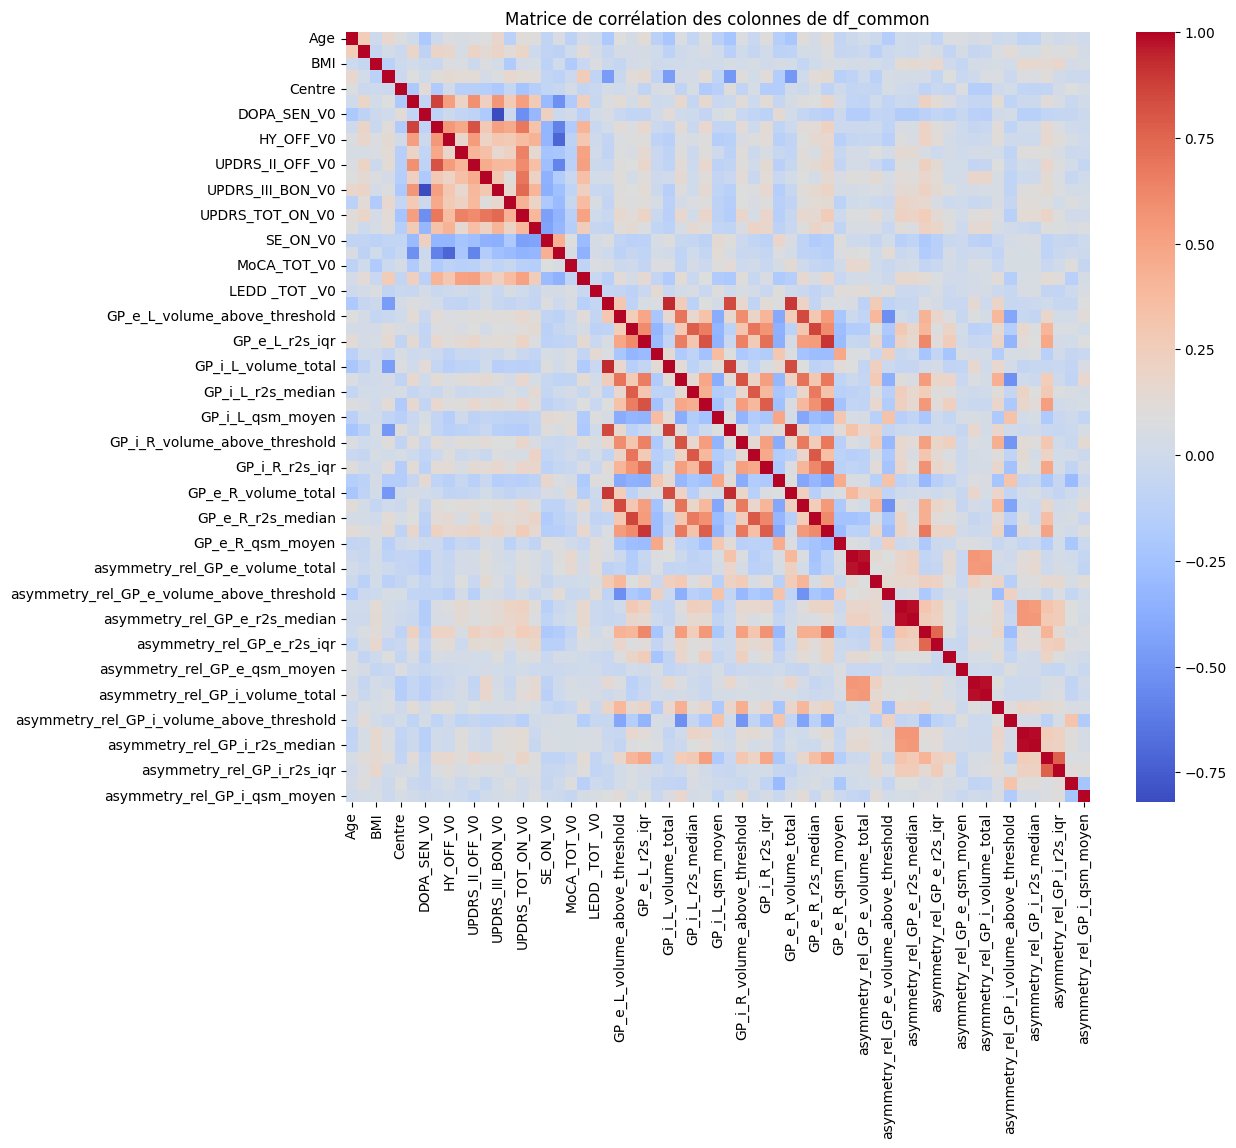

In [11]:
# Sélectionner uniquement les colonnes numériques
numeric_columns = df_common.select_dtypes(include=[np.number])

# Calculer la matrice de corrélation
correlation_matrix = numeric_columns.corr()

# Visualiser la matrice de corrélation avec une heatmap sans annotations
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=False, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Matrice de corrélation des colonnes de df_common")
plt.savefig('/NAS/deathrow/protocoles/predistim/screenshots/correlation_matrix.png', dpi=300)
plt.show()

In [12]:
df1.filter(regex="^(DOPA|UPDRS)", axis=1).columns

Index(['UPDRS_III_WOFF_V0', 'DOPA_SEN_V0', 'UPDRS_TOT_OFF_V0', 'UPDRS_I _V0',
       'UPDRS_II_OFF_V0', 'UPDRS_II_ON_V0', 'UPDRS_III_BON_V0', 'UPDRS_IV _V0',
       'UPDRS_TOT_ON_V0'],
      dtype='object')

Index(['UPDRS_III_WOFF_V0', 'DOPA_SEN_V0', 'UPDRS_TOT_OFF_V0', 'UPDRS_I _V0',
       'UPDRS_II_OFF_V0', 'UPDRS_II_ON_V0', 'UPDRS_III_BON_V0', 'UPDRS_IV _V0',
       'UPDRS_TOT_ON_V0'],
      dtype='object')


IndexError: index 0 is out of bounds for axis 0 with size 0

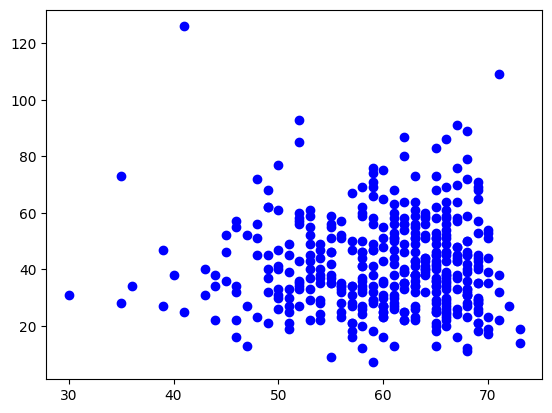

In [13]:
listeTargetVar=df1.filter(regex="^(DOPA|UPDRS)", axis=1).columns
print(listeTargetVar)
lbr.regress_covar_func(listeTargetVar,["Age"],df_common,df_common,display=True)

In [ ]:
def pearsonr_ci(x, y, alpha=0.05):
    """Calculate the Pearson correlation coefficient and its confidence interval."""
    r, p = pearsonr(x, y)
    n = len(x)
    # Standard error for Fisher's z-transformation
    se = 1 / np.sqrt(n - 3)
    
    # Fisher's z-transformation of the Pearson correlation coefficient
    z = np.arctanh(r)
    
    # Calculate the confidence interval in the z-space
    z_ci = [z - se * 1.96, z + se * 1.96]  # 95% confidence interval
    
    # Transform the confidence interval back to the r-space using the hyperbolic tangent
    r_ci = np.tanh(z_ci)
    
    return r, p, r_ci

In [15]:
df_common.filter(regex="^(GP)", axis=1).columns

Index(['GP_e_L_volume_total', 'GP_e_L_volume_above_threshold',
       'GP_e_L_r2s_median', 'GP_e_L_r2s_iqr', 'GP_e_L_qsm_moyen',
       'GP_i_L_volume_total', 'GP_i_L_volume_above_threshold',
       'GP_i_L_r2s_median', 'GP_i_L_r2s_iqr', 'GP_i_L_qsm_moyen',
       'GP_i_R_volume_total', 'GP_i_R_volume_above_threshold',
       'GP_i_R_r2s_median', 'GP_i_R_r2s_iqr', 'GP_i_R_qsm_moyen',
       'GP_e_R_volume_total', 'GP_e_R_volume_above_threshold',
       'GP_e_R_r2s_median', 'GP_e_R_r2s_iqr', 'GP_e_R_qsm_moyen'],
      dtype='object')

In [16]:
# Check if the required columns exist in df_common
for col in df1.filter(regex="^(DOPA|UPDRS)", axis=1):
    #print(f"Processing column: {col}")
    # Create a scatter plot with a trendline
    for asymmetry_col in df_common.filter(regex="^(GP|asymmetry)", axis=1).columns : #["asymmetry_abs_GP_e_qsm_moyen", "asymmetry_abs_GP_e_r2s_median"]:
        print(f"Processing columns:  {col} {asymmetry_col}")
        # Calculate Pearson correlation and confidence interval
        x_data = df_common[asymmetry_col]
        y_data = df_common[col]
        mask = ~x_data.isna() & ~y_data.isna()  # Filter NaN values
        r, p, r_ci = pearsonr_ci(x_data[mask], y_data[mask])
        print(f"Pearson correlation: r={r:.2f}, p-value={p:.2e}, CI=[{r_ci[0]:.2f}, {r_ci[1]:.2f}]")
        # Only display the plot if the correlation is greater than 0.2
        if abs(r) > 0.2 :
            for color_col in ["Age", "BMI"]:  # Include both Age and BMI
                fig = px.scatter(
                    df_common,
                    x=asymmetry_col,
                    y=col,
                    color=color_col,
                    trendline="ols",  # Add a trendline
                    title=(
                        f"Scatter plot with trendline ({col} vs {asymmetry_col})<br>"
                        f"r={r:.2f}, p={p:.2e}, CI=[{r_ci[0]:.2f}, {r_ci[1]:.2f}]"
                    ),
                    labels={
                        asymmetry_col: f"{asymmetry_col}",
                        #f"Absolute asymmetry of GP_e ({asymmetry_col.split('_')[-1]})",
                        color_col: color_col,
                        col: col
                    }
                )
                # Save the figure as an image
                fig.write_image(f"/NAS/deathrow/protocoles/predistim/screenshots/{col}_vs_{asymmetry_col}_colored_by_{color_col}.png")
                fig.show()


Processing columns:  UPDRS_III_WOFF_V0 GP_e_L_volume_total
Pearson correlation: r=0.08, p-value=1.75e-01, CI=[-0.04, 0.19]
Processing columns:  UPDRS_III_WOFF_V0 GP_e_L_volume_above_threshold
Pearson correlation: r=0.13, p-value=2.66e-02, CI=[0.02, 0.24]
Processing columns:  UPDRS_III_WOFF_V0 GP_e_L_r2s_median
Pearson correlation: r=0.03, p-value=6.66e-01, CI=[-0.09, 0.14]
Processing columns:  UPDRS_III_WOFF_V0 GP_e_L_r2s_iqr
Pearson correlation: r=0.14, p-value=1.76e-02, CI=[0.02, 0.25]
Processing columns:  UPDRS_III_WOFF_V0 GP_e_L_qsm_moyen
Pearson correlation: r=-0.01, p-value=8.18e-01, CI=[-0.13, 0.10]
Processing columns:  UPDRS_III_WOFF_V0 GP_i_L_volume_total
Pearson correlation: r=-0.00, p-value=9.95e-01, CI=[-0.12, 0.11]
Processing columns:  UPDRS_III_WOFF_V0 GP_i_L_volume_above_threshold
Pearson correlation: r=0.16, p-value=7.63e-03, CI=[0.04, 0.27]
Processing columns:  UPDRS_III_WOFF_V0 GP_i_L_r2s_median
Pearson correlation: r=-0.06, p-value=3.00e-01, CI=[-0.17, 0.05]
Processi

Processing columns:  UPDRS_III_WOFF_V0 asymmetry_rel_GP_e_r2s_iqr
Pearson correlation: r=0.13, p-value=3.03e-02, CI=[0.01, 0.24]
Processing columns:  UPDRS_III_WOFF_V0 asymmetry_abs_GP_e_qsm_moyen
Pearson correlation: r=0.06, p-value=3.29e-01, CI=[-0.06, 0.17]
Processing columns:  UPDRS_III_WOFF_V0 asymmetry_rel_GP_e_qsm_moyen
Pearson correlation: r=-0.03, p-value=6.12e-01, CI=[-0.15, 0.09]
Processing columns:  UPDRS_III_WOFF_V0 asymmetry_abs_GP_i_volume_total
Pearson correlation: r=-0.06, p-value=2.95e-01, CI=[-0.17, 0.05]
Processing columns:  UPDRS_III_WOFF_V0 asymmetry_rel_GP_i_volume_total
Pearson correlation: r=-0.07, p-value=2.64e-01, CI=[-0.18, 0.05]
Processing columns:  UPDRS_III_WOFF_V0 asymmetry_abs_GP_i_volume_above_threshold
Pearson correlation: r=0.13, p-value=3.00e-02, CI=[0.01, 0.24]
Processing columns:  UPDRS_III_WOFF_V0 asymmetry_rel_GP_i_volume_above_threshold
Pearson correlation: r=-0.09, p-value=1.58e-01, CI=[-0.21, 0.03]
Processing columns:  UPDRS_III_WOFF_V0 asymm

Processing columns:  UPDRS_TOT_OFF_V0 GP_e_R_qsm_moyen
Pearson correlation: r=-0.03, p-value=6.28e-01, CI=[-0.14, 0.09]
Processing columns:  UPDRS_TOT_OFF_V0 asymmetry_abs_GP_e_volume_total
Pearson correlation: r=-0.03, p-value=5.97e-01, CI=[-0.15, 0.08]
Processing columns:  UPDRS_TOT_OFF_V0 asymmetry_rel_GP_e_volume_total
Pearson correlation: r=-0.03, p-value=6.00e-01, CI=[-0.15, 0.08]
Processing columns:  UPDRS_TOT_OFF_V0 asymmetry_abs_GP_e_volume_above_threshold
Pearson correlation: r=-0.01, p-value=8.18e-01, CI=[-0.13, 0.10]
Processing columns:  UPDRS_TOT_OFF_V0 asymmetry_rel_GP_e_volume_above_threshold
Pearson correlation: r=-0.09, p-value=1.10e-01, CI=[-0.21, 0.02]
Processing columns:  UPDRS_TOT_OFF_V0 asymmetry_abs_GP_e_r2s_median
Pearson correlation: r=0.06, p-value=3.49e-01, CI=[-0.06, 0.17]
Processing columns:  UPDRS_TOT_OFF_V0 asymmetry_rel_GP_e_r2s_median
Pearson correlation: r=0.04, p-value=4.80e-01, CI=[-0.07, 0.16]
Processing columns:  UPDRS_TOT_OFF_V0 asymmetry_abs_GP_e

Processing columns:  UPDRS_TOT_OFF_V0 asymmetry_rel_GP_e_r2s_iqr
Pearson correlation: r=0.10, p-value=8.78e-02, CI=[-0.01, 0.21]
Processing columns:  UPDRS_TOT_OFF_V0 asymmetry_abs_GP_e_qsm_moyen
Pearson correlation: r=0.06, p-value=3.49e-01, CI=[-0.06, 0.17]
Processing columns:  UPDRS_TOT_OFF_V0 asymmetry_rel_GP_e_qsm_moyen
Pearson correlation: r=-0.01, p-value=8.29e-01, CI=[-0.13, 0.10]
Processing columns:  UPDRS_TOT_OFF_V0 asymmetry_abs_GP_i_volume_total
Pearson correlation: r=-0.05, p-value=3.61e-01, CI=[-0.17, 0.06]
Processing columns:  UPDRS_TOT_OFF_V0 asymmetry_rel_GP_i_volume_total
Pearson correlation: r=-0.04, p-value=4.63e-01, CI=[-0.16, 0.07]
Processing columns:  UPDRS_TOT_OFF_V0 asymmetry_abs_GP_i_volume_above_threshold
Pearson correlation: r=0.11, p-value=6.17e-02, CI=[-0.01, 0.22]
Processing columns:  UPDRS_TOT_OFF_V0 asymmetry_rel_GP_i_volume_above_threshold
Pearson correlation: r=-0.09, p-value=1.44e-01, CI=[-0.21, 0.03]
Processing columns:  UPDRS_TOT_OFF_V0 asymmetry_a

Processing columns:  UPDRS_II_OFF_V0 asymmetry_rel_GP_e_r2s_iqr
Pearson correlation: r=0.13, p-value=2.76e-02, CI=[0.02, 0.25]
Processing columns:  UPDRS_II_OFF_V0 asymmetry_abs_GP_e_qsm_moyen
Pearson correlation: r=0.02, p-value=7.97e-01, CI=[-0.10, 0.14]
Processing columns:  UPDRS_II_OFF_V0 asymmetry_rel_GP_e_qsm_moyen
Pearson correlation: r=0.01, p-value=8.52e-01, CI=[-0.11, 0.13]
Processing columns:  UPDRS_II_OFF_V0 asymmetry_abs_GP_i_volume_total
Pearson correlation: r=-0.07, p-value=2.31e-01, CI=[-0.19, 0.05]
Processing columns:  UPDRS_II_OFF_V0 asymmetry_rel_GP_i_volume_total
Pearson correlation: r=-0.06, p-value=3.68e-01, CI=[-0.17, 0.07]
Processing columns:  UPDRS_II_OFF_V0 asymmetry_abs_GP_i_volume_above_threshold
Pearson correlation: r=0.09, p-value=1.59e-01, CI=[-0.03, 0.20]
Processing columns:  UPDRS_II_OFF_V0 asymmetry_rel_GP_i_volume_above_threshold
Pearson correlation: r=-0.06, p-value=3.84e-01, CI=[-0.18, 0.07]
Processing columns:  UPDRS_II_OFF_V0 asymmetry_abs_GP_i_r2

Processing columns:  UPDRS_III_BON_V0 GP_e_R_qsm_moyen
Pearson correlation: r=0.04, p-value=5.41e-01, CI=[-0.08, 0.15]
Processing columns:  UPDRS_III_BON_V0 asymmetry_abs_GP_e_volume_total
Pearson correlation: r=0.04, p-value=5.17e-01, CI=[-0.08, 0.15]
Processing columns:  UPDRS_III_BON_V0 asymmetry_rel_GP_e_volume_total
Pearson correlation: r=0.04, p-value=4.52e-01, CI=[-0.07, 0.16]
Processing columns:  UPDRS_III_BON_V0 asymmetry_abs_GP_e_volume_above_threshold
Pearson correlation: r=0.07, p-value=2.62e-01, CI=[-0.05, 0.18]
Processing columns:  UPDRS_III_BON_V0 asymmetry_rel_GP_e_volume_above_threshold
Pearson correlation: r=0.03, p-value=5.71e-01, CI=[-0.08, 0.15]
Processing columns:  UPDRS_III_BON_V0 asymmetry_abs_GP_e_r2s_median
Pearson correlation: r=0.15, p-value=1.27e-02, CI=[0.03, 0.26]
Processing columns:  UPDRS_III_BON_V0 asymmetry_rel_GP_e_r2s_median
Pearson correlation: r=0.13, p-value=2.41e-02, CI=[0.02, 0.24]
Processing columns:  UPDRS_III_BON_V0 asymmetry_abs_GP_e_r2s_iq

Processing columns:  UPDRS_III_BON_V0 asymmetry_rel_GP_e_r2s_iqr
Pearson correlation: r=0.13, p-value=2.36e-02, CI=[0.02, 0.24]
Processing columns:  UPDRS_III_BON_V0 asymmetry_abs_GP_e_qsm_moyen
Pearson correlation: r=0.09, p-value=1.09e-01, CI=[-0.02, 0.21]
Processing columns:  UPDRS_III_BON_V0 asymmetry_rel_GP_e_qsm_moyen
Pearson correlation: r=0.01, p-value=8.34e-01, CI=[-0.10, 0.13]
Processing columns:  UPDRS_III_BON_V0 asymmetry_abs_GP_i_volume_total
Pearson correlation: r=0.03, p-value=5.72e-01, CI=[-0.08, 0.15]
Processing columns:  UPDRS_III_BON_V0 asymmetry_rel_GP_i_volume_total
Pearson correlation: r=0.05, p-value=4.37e-01, CI=[-0.07, 0.16]
Processing columns:  UPDRS_III_BON_V0 asymmetry_abs_GP_i_volume_above_threshold
Pearson correlation: r=0.05, p-value=4.18e-01, CI=[-0.07, 0.16]
Processing columns:  UPDRS_III_BON_V0 asymmetry_rel_GP_i_volume_above_threshold
Pearson correlation: r=-0.09, p-value=1.66e-01, CI=[-0.21, 0.04]
Processing columns:  UPDRS_III_BON_V0 asymmetry_abs_G

Processing columns:  UPDRS_TOT_ON_V0 GP_e_R_qsm_moyen
Pearson correlation: r=-0.01, p-value=8.06e-01, CI=[-0.13, 0.10]
Processing columns:  UPDRS_TOT_ON_V0 asymmetry_abs_GP_e_volume_total
Pearson correlation: r=0.08, p-value=2.02e-01, CI=[-0.04, 0.19]
Processing columns:  UPDRS_TOT_ON_V0 asymmetry_rel_GP_e_volume_total
Pearson correlation: r=0.08, p-value=2.00e-01, CI=[-0.04, 0.19]
Processing columns:  UPDRS_TOT_ON_V0 asymmetry_abs_GP_e_volume_above_threshold
Pearson correlation: r=0.13, p-value=3.16e-02, CI=[0.01, 0.24]
Processing columns:  UPDRS_TOT_ON_V0 asymmetry_rel_GP_e_volume_above_threshold
Pearson correlation: r=0.02, p-value=7.14e-01, CI=[-0.10, 0.14]
Processing columns:  UPDRS_TOT_ON_V0 asymmetry_abs_GP_e_r2s_median
Pearson correlation: r=0.22, p-value=2.05e-04, CI=[0.11, 0.33]


Processing columns:  UPDRS_TOT_ON_V0 asymmetry_rel_GP_e_r2s_median
Pearson correlation: r=0.20, p-value=8.27e-04, CI=[0.08, 0.31]
Processing columns:  UPDRS_TOT_ON_V0 asymmetry_abs_GP_e_r2s_iqr
Pearson correlation: r=0.25, p-value=1.68e-05, CI=[0.14, 0.36]


Processing columns:  UPDRS_TOT_ON_V0 asymmetry_rel_GP_e_r2s_iqr
Pearson correlation: r=0.13, p-value=2.44e-02, CI=[0.02, 0.25]
Processing columns:  UPDRS_TOT_ON_V0 asymmetry_abs_GP_e_qsm_moyen
Pearson correlation: r=0.08, p-value=2.04e-01, CI=[-0.04, 0.19]
Processing columns:  UPDRS_TOT_ON_V0 asymmetry_rel_GP_e_qsm_moyen
Pearson correlation: r=0.02, p-value=7.76e-01, CI=[-0.10, 0.13]
Processing columns:  UPDRS_TOT_ON_V0 asymmetry_abs_GP_i_volume_total
Pearson correlation: r=0.10, p-value=8.30e-02, CI=[-0.01, 0.22]
Processing columns:  UPDRS_TOT_ON_V0 asymmetry_rel_GP_i_volume_total
Pearson correlation: r=0.11, p-value=5.70e-02, CI=[-0.00, 0.23]
Processing columns:  UPDRS_TOT_ON_V0 asymmetry_abs_GP_i_volume_above_threshold
Pearson correlation: r=0.07, p-value=2.44e-01, CI=[-0.05, 0.18]
Processing columns:  UPDRS_TOT_ON_V0 asymmetry_rel_GP_i_volume_above_threshold
Pearson correlation: r=-0.14, p-value=3.16e-02, CI=[-0.26, -0.01]
Processing columns:  UPDRS_TOT_ON_V0 asymmetry_abs_GP_i_r2s

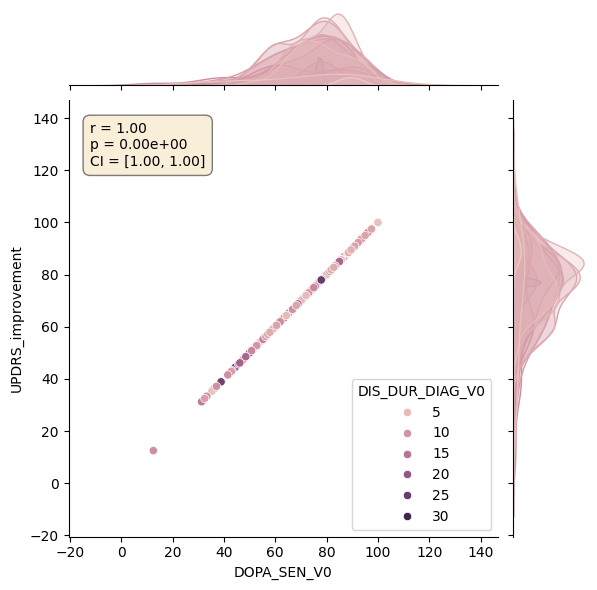

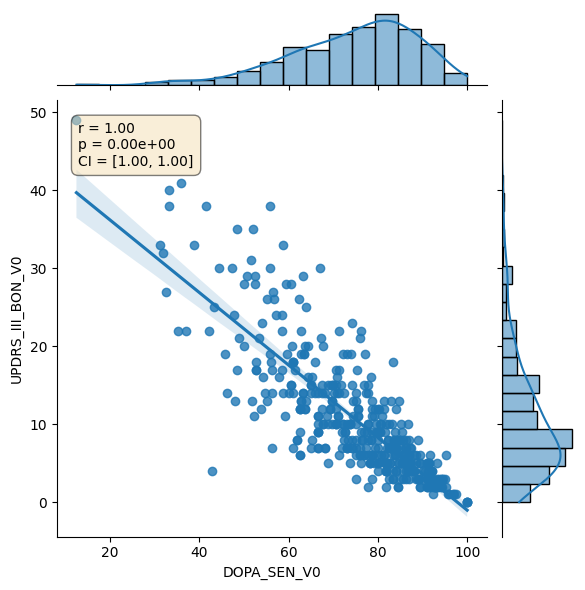

In [56]:
from scipy.stats import pearsonr
import numpy as np

import plotly.express as px

# Assuming pearsonr_ci is defined as in CELL 16
# If not, you'll need to define it here or ensure it's available in the scope.
# def pearsonr_ci(x, y, alpha=0.05):
#     """Calculate the Pearson correlation coefficient and its confidence interval."""
#     r, p = pearsonr(x, y)
#     n = len(x)
#     # Standard error for Fisher's z-transformation
#     se = 1 / np.sqrt(n - 3)
#     # Fisher's z-transformation of the Pearson correlation coefficient
#     z = np.arctanh(r)
#     # Calculate the confidence interval in the z-space
#     z_ci = [z - se * 1.96, z + se * 1.96]  # 95% confidence interval
#     # Transform the confidence interval back to the r-space using the hyperbolic tangent
#     r_ci = np.tanh(z_ci)
#     return r, p, r_ci

# Extract data for correlation
x_data = df_common['DOPA_SEN_V0']
y_data = df_common['UPDRS_TOT_ON_V0']

# Filter NaN values for correlation calculation
mask = ~x_data.isna() & ~y_data.isna()
r, p, r_ci = pearsonr_ci(x_data[mask], y_data[mask])

# Create the jointplot
#'UPDRS_III_WOFF_V0', 'DOPA_SEN_V0', 'UPDRS_TOT_OFF_V0', 'UPDRS_I _V0','UPDRS_II_OFF_V0', 'UPDRS_II_ON_V0', 'UPDRS_III_BON_V0', 'UPDRS_IV _V0','UPDRS_TOT_ON_V0']
#UPDRS_TOT_ON_V0
#UPDRS_III_WOFF_V0
# Create a new column in df_common
#df_common['UPDRS_improvement'] = 100 - ((df_common['UPDRS_III_BON_V0'] / df_common['UPDRS_III_WOFF_V0']) * 100)
df_common['UPDRS_improvement'] = ((df_common['UPDRS_III_WOFF_V0'] - df_common['UPDRS_III_BON_V0'])/ df_common['UPDRS_III_WOFF_V0']) * 100
# Extract data for correlation
x_data = df_common['DOPA_SEN_V0']
y_data = df_common['UPDRS_improvement']

# Filter NaN values for correlation calculation
mask = ~x_data.isna() & ~y_data.isna()
r, p, r_ci = pearsonr_ci(x_data[mask], y_data[mask])

# Create the jointplot
g = sns.jointplot(x='DOPA_SEN_V0', y='UPDRS_improvement',hue="DIS_DUR_DIAG_V0", data=df_common)

# Add correlation information to the plot
text_str = f'r = {r:.2f}\np = {p:.2e}\nCI = [{r_ci[0]:.2f}, {r_ci[1]:.2f}]'
plt.text(0.05, 0.95, text_str, transform=g.ax_joint.transAxes, 
         fontsize=10, verticalalignment='top', bbox=dict(boxstyle='round,pad=0.5', fc='wheat', alpha=0.5))
plt.show()

#UPDRS_III_BON_V0
g = sns.jointplot(x='DOPA_SEN_V0', y='UPDRS_III_BON_V0', data=df_common, kind='reg')

# Add correlation information to the plot
text_str = f'r = {r:.2f}\np = {p:.2e}\nCI = [{r_ci[0]:.2f}, {r_ci[1]:.2f}]'
plt.text(0.05, 0.95, text_str, transform=g.ax_joint.transAxes, 
         fontsize=10, verticalalignment='top', bbox=dict(boxstyle='round,pad=0.5', fc='wheat', alpha=0.5))
#plt.savefig(f"/NAS/deathrow/protocoles/predistim/screenshots/DOPA_vs_UPDRS_TOT_ON_V0.png")
plt.show()

In [33]:
from sklearn.linear_model import LinearRegression

def unconfound(y, confound, group_data=False):
    lr = LinearRegression(fit_intercept=True).fit(confound, y)  # lr.coef_: [targets, confounds]
    if group_data:
        y_predicted_by_confound = lr.coef_[:, 1:] @ confound[:, 1:].T
    else:
        y_predicted_by_confound = lr.coef_ @ confound.T  # [targets, samples]
    y_corrected = y.T - y_predicted_by_confound
    return y_corrected.T  # [samples, targets]

In [46]:
# Create a list to store the results
results_list = []
# Check if the required columns exist in df_common
for col in df1.filter(regex="^(DOPA|UPDRS)", axis=1):
    # Create a scatter plot with a trendline
    for asymmetry_col in df_common.filter(regex="^(GP|asymmetry)", axis=1).columns:
        print(f"Processing columns: {col} {asymmetry_col}")
        # Calculate Pearson correlation and confidence interval
        x_data = df_common[asymmetry_col]
        y_data = df_common[col]
        age=df_common["Age"]
        BMI=df_common["BMI"]
        mask = ~x_data.isna() & ~y_data.isna() & ~age.isna() & ~BMI.isna()  # Filter NaN values
        # Regress Age and BMI
        x_age_AgeCor = unconfound(x_data[mask].values.reshape(-1, 1), age[mask].values.reshape(-1, 1)).flatten()
        x_age_AgeAndBMICor = unconfound(x_age_AgeCor.reshape(-1, 1), BMI[mask].values.reshape(-1, 1)).flatten()

        r, p, r_ci = pearsonr_ci(x_data[mask], y_data[mask])
        print(f"Pearson correlation: r={r:.2f}, p-value={p:.2e}, CI=[{r_ci[0]:.2f}, {r_ci[1]:.2f}]")
        # Append the results to the list
        results_list.append({
            "col": col,
            "asymmetry_col": asymmetry_col,
            "r": r,
            "p-value": p,
            "CI_lower": r_ci[0],
            "CI_upper": r_ci[1]
        })
        # Only display the plot if the correlation is greater than 0.2
        if abs(r) > 0.2:
            fig = px.scatter(
                df_common,
                x=asymmetry_col,
                y=col,
                trendline="ols",  # Add a trendline
                title=(
                    f"Scatter plot with trendline ({col} vs {asymmetry_col})<br>"
                    f"r={r:.2f}, p={p:.2e}, CI=[{r_ci[0]:.2f}, {r_ci[1]:.2f}]"
                ),
                labels={
                    asymmetry_col: f"{asymmetry_col}",
                        color_col: color_col,
                        col: col
                    }
                )
                # Save the figure as an image
            fig.write_image(f"/NAS/deathrow/protocoles/predistim/screenshots/{col}_vs_{asymmetry_col}_cov.png")


# Convert the results list to a DataFrame
results_df = pd.DataFrame(results_list)

# Save the results to a CSV file
results_df.to_csv('/NAS/deathrow/protocoles/predistim/asym_correlation_results.csv', index=False)


Processing columns: UPDRS_III_WOFF_V0 GP_e_L_volume_total
Pearson correlation: r=0.10, p-value=9.42e-02, CI=[-0.02, 0.22]
Processing columns: UPDRS_III_WOFF_V0 GP_e_L_volume_above_threshold
Pearson correlation: r=0.10, p-value=1.01e-01, CI=[-0.02, 0.22]
Processing columns: UPDRS_III_WOFF_V0 GP_e_L_r2s_median
Pearson correlation: r=0.02, p-value=7.89e-01, CI=[-0.10, 0.14]
Processing columns: UPDRS_III_WOFF_V0 GP_e_L_r2s_iqr
Pearson correlation: r=0.12, p-value=4.86e-02, CI=[0.00, 0.24]
Processing columns: UPDRS_III_WOFF_V0 GP_e_L_qsm_moyen
Pearson correlation: r=-0.03, p-value=6.06e-01, CI=[-0.15, 0.09]
Processing columns: UPDRS_III_WOFF_V0 GP_i_L_volume_total
Pearson correlation: r=0.02, p-value=7.18e-01, CI=[-0.10, 0.14]
Processing columns: UPDRS_III_WOFF_V0 GP_i_L_volume_above_threshold
Pearson correlation: r=0.14, p-value=2.55e-02, CI=[0.02, 0.25]
Processing columns: UPDRS_III_WOFF_V0 GP_i_L_r2s_median
Pearson correlation: r=-0.07, p-value=2.44e-01, CI=[-0.19, 0.05]
Processing colum

In [55]:
# Scatter plot with regression line for Age and BMI corrected GP_e_r2s_iqr vs UPDRS_TOT_OFF_V0
r, p, r_ci = pearsonr_ci(combined_df['GP_e_r2s_iqr_AgeAndBMICorrected'], combined_df['UPDRS_TOT_OFF_V0'])
fig = px.scatter(
    combined_df,
    x='GP_e_r2s_iqr_AgeAndBMICorrected',
    y='UPDRS_TOT_OFF_V0',
    trendline="ols",
    title=(
        f"Scatter plot with trendline (GP_e_r2s_iqr_AgeAndBMICorrected vs UPDRS_TOT_OFF_V0)<br>"
        f"r={r:.2f}, p={p:.2e}, CI=[{r_ci[0]:.2f}, {r_ci[1]:.2f}]"
    ),
    labels={
        'GP_e_r2s_iqr_AgeAndBMICorrected': 'GP_e_r2s_iqr (Age and BMI Corrected)',
        'UPDRS_TOT_OFF_V0': 'UPDRS_TOT_OFF_V0'
    }
)
fig.show()

fig.write_image(f"/NAS/deathrow/protocoles/predistim/screenshots/GP_e_r2s_IQR_AgeAndBMICorrected_vs_UPDRS_TOT_OFF_V0.png")

# Scatter plot with regression line for Age and BMI corrected GP_e_r2s_iqr vs UPDRS_TOT_ON_V0
r, p, r_ci = pearsonr_ci(combined_df['GP_e_r2s_iqr_AgeAndBMICorrected'], combined_df['UPDRS_TOT_ON_V0'])
fig = px.scatter(
    combined_df,
    x='GP_e_r2s_iqr_AgeAndBMICorrected',
    y='UPDRS_TOT_ON_V0',
    trendline="ols",
    title=(
        f"Scatter plot with trendline (GP_e_r2s_iqr_AgeAndBMICorrected vs UPDRS_TOT_ON_V0)<br>"
        f"r={r:.2f}, p={p:.2e}, CI=[{r_ci[0]:.2f}, {r_ci[1]:.2f}]"
    ),
    labels={
        'GP_e_r2s_iqr_AgeAndBMICorrected': 'GP_e_r2s_iqr (Age and BMI Corrected)',
        'UPDRS_TOT_ON_V0': 'UPDRS_TOT_ON_V0'
    }
)
fig.show()

fig.write_image(f"/NAS/deathrow/protocoles/predistim/screenshots/GP_e_r2s_IQR_AgeAndBMICorrected_vs_UPDRS_TOT_ON_V0.png")


In [19]:
for region, value in region_mapping.items():
    region_mask = (image_struct == value)
    
    # Calcul de la médiane et de l'IQR pour image_R2s
    region_values_R2s = image_R2s[region_mask]
    median_R2s = np.median(region_values_R2s)
    iqr_R2s = np.percentile(region_values_R2s, 75) - np.percentile(region_values_R2s, 25)
    threshold_R2s = median_R2s + 2 * iqr_R2s
    
    # Histogramme pour image_R2s
    plt.figure(figsize=(10, 5))
    sns.histplot(region_values_R2s, bins=50, kde=False, color='blue', label='R2s')
    plt.axvline(threshold_R2s, color='red', linestyle='--', label='Median + 3*IQR')
    plt.title(f"Histogram of R2s for {region}")
    plt.xlabel("R2s Values")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()
    
    # Calcul de la médiane et de l'IQR pour image_QSM
    region_values_QSM = image_QSM[region_mask]
    median_QSM = np.median(region_values_QSM)
    iqr_QSM = np.percentile(region_values_QSM, 75) - np.percentile(region_values_QSM, 25)
    threshold_QSM = median_QSM + 3 * iqr_QSM
    
    # Histogramme pour image_QSM
    plt.figure(figsize=(10, 5))
    sns.histplot(region_values_QSM, bins=50, kde=False, color='green', label='QSM')
    plt.axvline(threshold_QSM, color='red', linestyle='--', label='Median + 3*IQR')
    plt.title(f"Histogram of QSM for {region}")
    plt.xlabel("QSM Values")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()

NameError: name 'image_struct' is not defined

# Figure 4.C de l'article "Mapping microstructural gradients of the human striatum in normal aging and Parkinson’s disease" elior and aviv
# https://www.science.org/doi/10.1126/sciadv.abm1971

Pour recuper les identifiants avec un carte R2

In [ ]:
import glob

# Lister les fichiers dans le dossier
files = glob.glob('/NAS/deathrow/protocoles/predistim/T1WdivT2W/*_ratio.nii.gz')

# Extraire les identifiants sujets au format XX-YYY
subject_list = []
for f in files:
    basename = os.path.basename(f)
    if len(basename) >= 8:
        code = basename[:6]  # ex: 01011B
        subject_id = f"{code[:2]}-{code[2:5]}"
        subject_list.append(subject_id)

print(len(subject_list),subject_list)

438 ['19-051', '19-049', '02-012', '02-009', '02-006', '01-014', '02-004', '01-029', '01-027', '01-026', '01-050', '01-038', '05-002', '02-059', '02-038', '02-025', '02-053', '02-078', '02-040', '02-036', '02-046', '06-027', '06-025', '05-034', '05-018', '05-035', '06-009', '05-016', '05-023', '06-014', '06-012', '06-029', '05-031', '06-045', '06-048', '06-067', '06-042', '06-049', '06-039', '06-040', '06-062', '07-039', '07-035', '06-093', '07-018', '07-015', '07-027', '06-086', '07-016', '07-040', '06-089', '07-021', '07-087', '07-063', '07-064', '07-069', '07-090', '07-098', '07-097', '09-010', '07-092', '08-007', '09-018', '11-008', '09-016', '14-015', '14-026', '11-031', '11-024', '15-029', '14-025', '14-029', '11-014', '11-027', '17-016', '17-020', '17-041', '17-024', '17-023', '17-038', '18-003', '17-078', '19-011', '19-019', '19-021', '19-041', '06-026', '06-068', '01-059', '01-011', '01-028', '02-065', '02-051', '05-027', '01-039', '02-021', '01-035', '01-034', '02-089', '01-0

1. lecture du fichier de données avec les scores UPDRS III complet
2. on recupère  les colonnes DROIT/GAUCHE ON/OFF

In [ ]:
#1

df_msa = pd.read_excel(os.path.join(pl.STUDY_PATH, "csv_xlsx", "Romain_Juin2025.xlsx"), engine='openpyxl',sheet_name='UPDRSIII_COMPLET_V0')
print(df_msa.head())

df_msa.set_index("SUBJID", inplace=True)


#2

# Afficher toutes les colonnes contenant "DROIT" dans leur nom
droit_columns = df_msa.filter(regex="O.*_.*DROIT", axis=1).columns
print(len(droit_columns),droit_columns)

# Afficher toutes les colonnes contenant "DROIT" dans leur nom
gauche_columns = df_msa.filter(regex="O.*_.*GCHE", axis=1).columns
print(len(gauche_columns),gauche_columns)

                             SUBJID                            V12H_APRES  \
0  Subject Identifier for the Study  réalisation après 12h d'arret L-Dopa   
1                            01-001                                   Oui   
2                            01-002                                   Oui   
3                            01-003                                   Oui   
4                            01-004                                   Oui   

                                  DEMIVIE_AGONISTE                   H_LDOPA  \
0  réalisation après 5 demie-vies d'arret agoniste  heure de prise de L Dopa   
1                                              Oui                     09:00   
2                                              Oui                     09:47   
3                                               .K                     09:00   
4                                              Oui                     09:25   

       DOSE_LDOPA      OFF_H       ON_H15       ON_H30  

intersection des listes 

In [ ]:
# Récupérer les sujets présents dans subject_list à partir de df_msa
df_msa_filtered = df_msa.loc[df_msa.index.intersection(subject_list)]
print(df_msa_filtered)

       V12H_APRES DEMIVIE_AGONISTE H_LDOPA DOSE_LDOPA  OFF_H ON_H15 ON_H30  \
SUBJID                                                                       
01-011        Oui              Oui   09:35        250  09:30  09:45  10:00   
01-014        Oui              Oui   10:00        300  09:50  10:15  10:30   
01-015        Oui              Oui   08:50        300  08:30  09:05  09:20   
01-016        Oui              Oui   09:50        250  09:50  10:05  10:20   
01-017        Oui              Oui   DM:DM        300  DM:DM    NaN  DM:DM   
...           ...              ...     ...        ...    ...    ...    ...   
19-048        Oui              Oui   09:40        300  09:15  09:55  10:10   
19-049        Oui              Oui   10:00        200  09:30  10:15  10:30   
19-050        Oui              Oui   10:00        205  09:25  10:15  10:30   
19-051        Oui              Oui   10:10        180  09:45  10:25  10:40   
19-052        Oui              Oui   09:55        150  09:25  10

on somme les colonnes à gauche et à droite

In [ ]:
df_msa_filtered['somme_droit'] = df_msa_filtered[droit_columns].apply(pd.to_numeric, errors='coerce').sum(axis=1)
df_msa_filtered['somme_gauche'] = df_msa_filtered[gauche_columns].apply(pd.to_numeric, errors='coerce').sum(axis=1)
df_msa_filtered['asymetry'] = df_msa_filtered['somme_droit'] - df_msa_filtered['somme_gauche']

/tmp/ipykernel_3023534/1477343037.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_romain_filtered['somme_droit'] = df_romain_filtered[droit_columns].apply(pd.to_numeric, errors='coerce').sum(axis=1)
/tmp/ipykernel_3023534/1477343037.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_romain_filtered['somme_gauche'] = df_romain_filtered[gauche_columns].apply(pd.to_numeric, errors='coerce').sum(axis=1)
/tmp/ipykernel_3023534/1477343037.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result 

supprimer le "-" au milieu de l'index

In [ ]:
df_msa_filtered.index = df_msa_filtered.index.str.replace("-", "", regex=False)

distribution des valeurs des "motor symptom asymmetry"

In [ ]:
import numpy as np

import plotly.graph_objects as go

# Calcul de la moyenne et de l'écart type
mean = df_msa_filtered['asymetry'].mean()
std = df_msa_filtered['asymetry'].std()

# Histogramme
fig = px.histogram(
    df_msa_filtered,
    x='asymetry',
    nbins=30,
    title=f"Distribution of Asymmetry (sum_right - sum_left)<br>N={len(df_msa_filtered)} subjects<br>Mean={mean:.2f}, Std Dev={std:.2f}",
    labels={'asymetry': "Motor Symptom Asymmetry"},
    color_discrete_sequence=['#636EFA']
)
fig.update_layout(bargap=0.1)

# Générer la courbe normale
x_vals = np.linspace(df_msa_filtered['asymetry'].min(), df_msa_filtered['asymetry'].max(), 200)
hist_y, bins = np.histogram(df_msa_filtered['asymetry'], bins=30)
bin_width = bins[1] - bins[0]
normal_y = (
    len(df_msa_filtered['asymetry']) * bin_width *
    (1/(std * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x_vals - mean)/std)**2)
)

fig.add_trace(go.Scatter(
    x=x_vals,
    y=normal_y,
    mode='lines',
    name='normal distribution',
    line=dict(color='red')
))

fig.show()
fig.write_image("/NAS/deathrow/protocoles/predistim/screenshots/asymetry_histogram.png")

# Supprimer les valeurs outliers par la note au CQ

In [16]:
np.set_printoptions(precision=3)
df1 = pd.read_excel(os.path.join(pl.STUDY_PATH,"csv_xlsx",'Analyse_Imagerie_Predistim_V4_20210208.xlsx'),engine='openpyxl',index_col=0)
df1.rename(columns={'MoCA_TOT _V0':'MoCA_TOT_V0'},inplace=True)
#df2 = pd.read_excel(os.path.join(STUDY_PATH,'Bio_Ima_Gen_V5_20210210.xlsx'),engine='openpyxl',index_col=0)
df2 = pd.read_excel(os.path.join(pl.STUDY_PATH,"csv_xlsx",'Bio_Ima_Gen_V3_20210205.xlsx'),engine='openpyxl',index_col=0)
df3 = pd.read_excel(os.path.join(pl.STUDY_PATH,"csv_xlsx",'FOG_ThomasO_20210205.xlsx'),engine='openpyxl',index_col=0,converters={'PatientNB':str})
df3 = df3.dropna(subset={'FOGQ4 V0','FOGQ4 V1'})['Différence FOGQ somme V0-V1 gravité']

df2=df2.loc[:,~df2.columns.str.startswith('R2_')]
df2=df2.loc[:,~df2.columns.str.startswith('QSM_')]
df2=df2.loc[:,~df2.columns.str.startswith('3DT1_')]
df1=df1.loc[:,~df1.columns.str.startswith('R2_')]

df1.index = df1.index.str[:-2]
df2.index = df2.index.str[:-2]

#df4.index = df4.index.str.slice(0, 2) + df4.index.str.slice(3)
#df1_common = df1.join(df4[['Cluster', 'Alteration_sup_1DS', 'MCIpoststim']], how='inner')
#df_common=df1_common.join(df2[['CQT1', 'CQTE']], how='left')
df_common=df1.join(df2[['CQT1', 'CQTE']], how='left')

df_common_filtered = df_common[(df_common['CQT1'] > 1) & (df_common['CQTE'] > 1)]
df_common_filtered.describe()

,Age,DIS_DUR_DIAG_V0,BMI,Sexe,Centre,UPDRS_III_WOFF_V0,DOPA_SEN_V0,UPDRS_TOT_OFF_V0,HY_OFF_V0,UPDRS_I _V0,...,UPDRS_IV _V0,UPDRS_TOT_ON_V0,HY_ON_V0,SE_ON_V0,SE_OFF_V0,MoCA_TOT_V0,PDQ39_TOT_V0,LEDD _TOT _V0,CQT1,CQTE
count,428.000000,426.000000,389.000000,428.000000,428.000000,410.000000,409.000000,409.000000,405.000000,406.000000,...,401.000000,398.000000,383.000000,391.000000,406.000000,395.000000,410.000000,372.000000,428.000000,428.000000
mean,60.102804,9.544601,24.784285,1.348131,9.165888,41.714634,74.443032,78.234719,2.606173,11.825123,...,8.486284,37.087940,1.347258,93.375959,68.177340,26.387342,52.429268,1604.697434,3.074766,2.789720
std,7.421640,3.893782,4.002659,0.476935,5.861641,16.740476,14.293210,26.675127,0.870209,5.455676,...,3.441720,14.815058,0.852797,8.878631,18.741334,2.659976,20.225891,3405.077862,0.458098,0.536872
min,30.000000,2.000000,15.622619,1.000000,1.000000,7.000000,12.500000,19.000000,1.000000,0.000000,...,0.000000,8.000000,0.000000,20.000000,10.000000,14.000000,8.000000,45.320000,2.000000,2.000000
25%,55.000000,7.000000,22.093170,1.000000,6.000000,29.000000,65.200000,60.000000,2.000000,8.000000,...,6.000000,26.250000,1.000000,90.000000,60.000000,25.000000,37.000000,962.860000,3.000000,2.000000
50%,62.000000,9.000000,24.567474,1.000000,7.000000,39.000000,76.900000,74.000000,2.500000,11.000000,...,8.000000,34.000000,1.500000,100.000000,70.000000,27.000000,52.000000,1291.000000,3.000000,3.000000
75%,66.000000,11.750000,27.281746,2.000000,17.000000,51.000000,84.800000,94.000000,3.000000,15.000000,...,11.000000,45.000000,2.000000,100.000000,80.000000,28.000000,67.000000,1653.750000,3.000000,3.000000
max,73.000000,32.000000,41.914342,2.000000,19.000000,126.000000,100.000000,166.000000,5.000000,32.000000,...,22.000000,98.000000,4.000000,100.000000,100.000000,30.000000,109.000000,62922.560000,4.000000,4.000000


lecture du fihier fait par MRgrad pour connaitre la valeurs par segments

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def plot_roi_profiles(excel_file, rois, axes_labels=['Axe1', 'Axe2', 'Axe3'], colors=['blue', 'red', 'green']):
    """
    Fonction pour visualiser les profils des ROI à partir d'un fichier Excel.

    Paramètres :
    - excel_file : Chemin vers le fichier Excel.
    - rois : Liste des noms des ROI à visualiser.
    - axes_labels : Liste des labels pour les axes (par défaut ['Axe1', 'Axe2', 'Axe3']).
    - colors : Liste des couleurs pour les graphiques (par défaut ['blue', 'red', 'green']).
    """
    # Lire toutes les feuilles du fichier Excel et définir la première colonne comme index
    sheets_dict = pd.read_excel(excel_file, sheet_name=None, engine='openpyxl')

    # Initialiser le dictionnaire de dictionnaires
    dict_of_dicts = {}

    # Parcourir chaque clé et DataFrame dans sheets_dict
    for key, df in sheets_dict.items():
        # Définir l'index et supprimer la colonne 'Row'
        df.index = df['Row']
        df.drop(columns=['Row'], inplace=True)
        df.index = df.index.str[:-2]

        # Séparer les colonnes en 3 axes
        df_axes = {
            'Axe1': df.iloc[:, :7],
            'Axe2': df.iloc[:, 7:14],
            'Axe3': df.iloc[:, 14:]
        }
        # Ajouter au dictionnaire de dictionnaires
        dict_of_dicts[key] = df_axes

    # Créer une figure avec des sous-graphiques
    fig, axs = plt.subplots(1, len(axes_labels), figsize=(18, 5), sharey=True)

    # Parcourir chaque axe
    for i, (axe, color) in enumerate(zip(axes_labels, colors)):
        ax = axs[i]

        # Parcourir chaque ROI
        for roi in rois:
            if roi in dict_of_dicts:
                roi_df = dict_of_dicts[roi][axe]
                mean = roi_df.mean(axis=0)
                std = roi_df.std(axis=0)
                x = np.arange(len(mean))

                # Tracer la moyenne et l'écart-type
                ax.plot(x, mean, color=color, label=roi, linestyle='-')
                ax.fill_between(x, mean - std, mean + std, color=color, alpha=0.2)

        ax.set_xlabel('Profile Position')
        ax.set_title(f'{axe}')
        if i == 0:
            ax.set_ylabel('Mean Value')
        ax.legend()

    plt.tight_layout()
    plt.show()


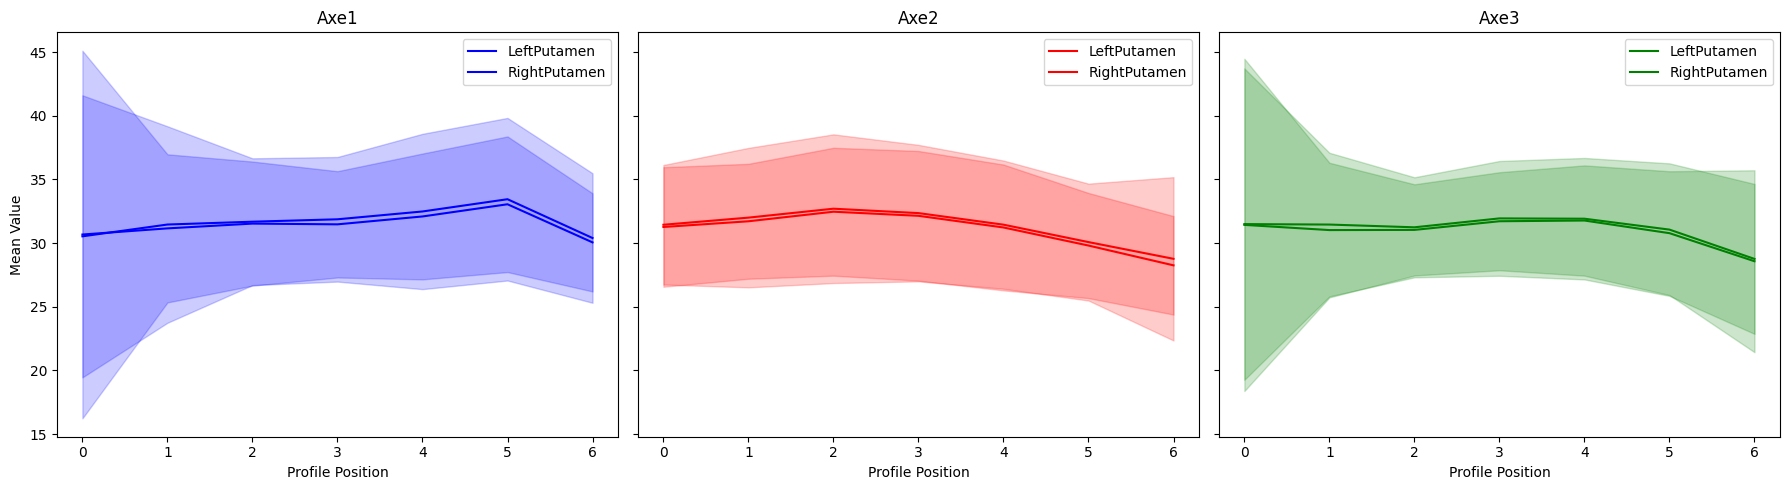

In [ ]:
# Exemple d'utilisation
excel_file = os.path.join(pl.STUDY_PATH,'code', 'mrGrad_AvivMezer', 'mrGradOuputs_PutamenVolbrain_R2.xlsx')
rois = ['LeftPutamen', 'RightPutamen']
plot_roi_profiles(excel_file, rois)

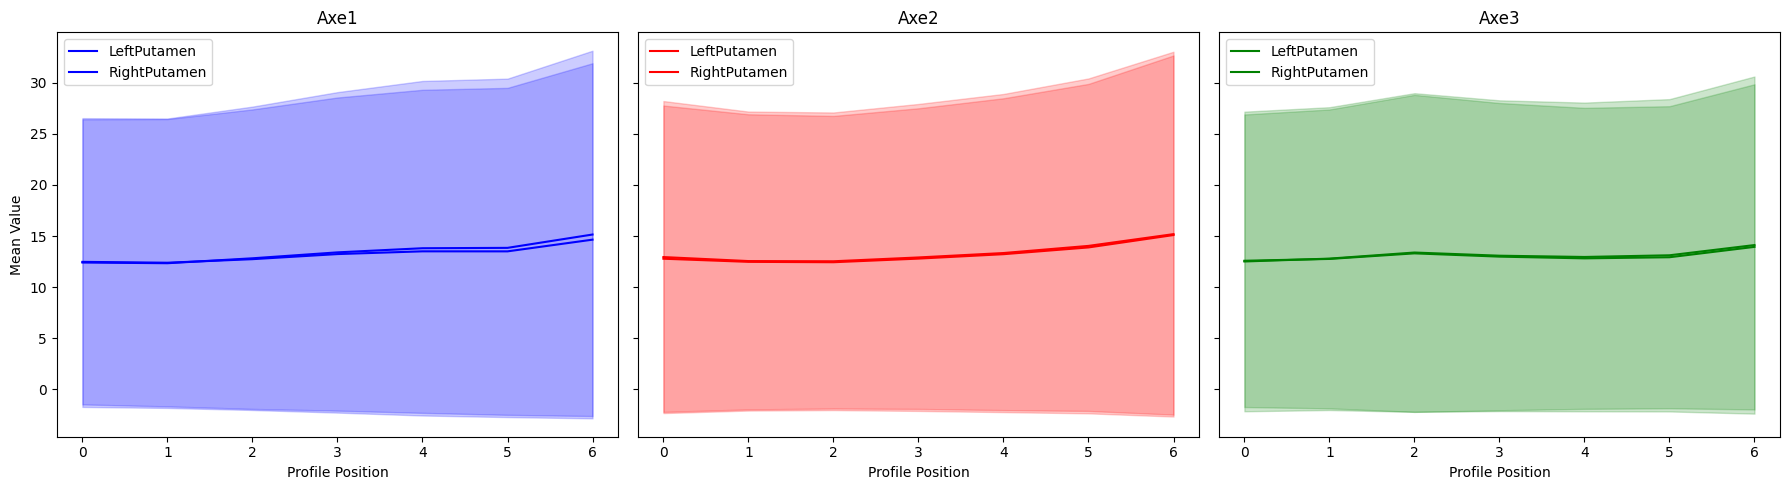

In [23]:
excel_file = os.path.join(pl.STUDY_PATH,'code', 'mrGrad_AvivMezer', 'mrGradOuputs_PutamenVolbrain_T1W_R2.xlsx')
rois = ['LeftPutamen', 'RightPutamen']
plot_roi_profiles(excel_file, rois)

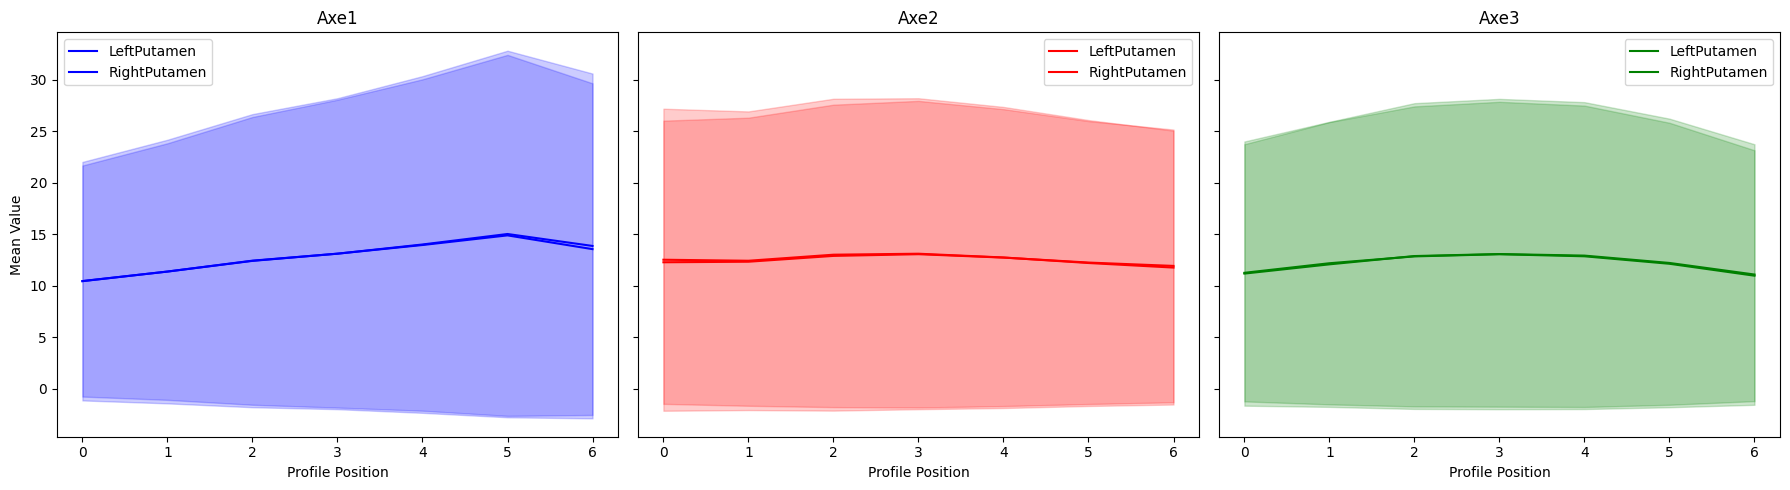

In [33]:
excel_file = os.path.join(pl.STUDY_PATH,'code', 'mrGrad_AvivMezer', 'mrGradOuputs_PutamenVolbrain_T1W_T2W.xlsx')
rois = ['LeftPutamen', 'RightPutamen']
plot_roi_profiles(excel_file, rois)

In [38]:
# Afficher un exemple pour vérifier
# Calculer la somme des trois dernières colonnes de Axe1 pour LeftPutamen
numerateur = (dict_of_dicts['LeftPutamen']['Axe1'].iloc[:, -3:].mean(axis=1) - dict_of_dicts['RightPutamen']['Axe1'].iloc[:, -3:].mean(axis=1))
denominateur = (dict_of_dicts['LeftPutamen']['Axe1'].iloc[:, -3:].mean(axis=1) + dict_of_dicts['RightPutamen']['Axe1'].iloc[:, -3:].mean(axis=1))/2
putamen_asymetry=numerateur/denominateur
print(putamen_asymetry)

Row
01011    0.021954
01014    0.083560
01015   -0.080819
01016   -0.064234
01017   -0.052730
           ...   
19048   -0.045218
19049    0.050498
19050    0.172769
19051    0.014984
19052    0.175258
Length: 437, dtype: float64


 # Ne passant pas le controle qualité

In [ ]:
set(putamen_asymetry.index) - set(df_msa_filtered.loc[df_common_filtered.index].index) 

{'02008',
 '02051',
 '05018',
 '07035',
 '07085',
 '08017',
 '09002',
 '18007',
 '19024',
 '19047'}

# pas d'asymetrie /imagerie

In [ ]:
df_msa_filtered=df_msa_filtered.drop('07015') 

In [52]:
df_common_filtered=df_common_filtered.drop('07015')

In [ ]:
set(df_msa_filtered.loc[df_msa_filtered.index].index) - set(putamen_asymetry.index)

set()

In [ ]:
putamen_asymetry.loc[df_msa_filtered.loc[df_common_filtered.index].index].values

KeyError: "['07015'] not in index"

In [ ]:
df_msa_filtered

,V12H_APRES,DEMIVIE_AGONISTE,H_LDOPA,DOSE_LDOPA,OFF_H,ON_H15,ON_H30,ON_H45,ON_H60,ON_H90,...,TOT_OFF_DRUG,TOT_ON_DRUG_1,TOT_ON_DRUG_2,TOT_ON_DRUG_3,TOT_ON_DRUG_4,TOT_ON_DRUG_5,TOT_ON_DRUG_6,somme_droit,somme_gauche,asymetry
SUBJID,,,,,,,,,,,,,,,,,,,,,
01011,Oui,Oui,09:35,250,09:30,09:45,10:00,10:15,10:40,11:00,...,25,10,9,6,6,6,7,21.0,35.0,-14.0
01014,Oui,Oui,10:00,300,09:50,10:15,10:30,10:45,11:00,11:30,...,34,31,18,6,4,10,15,28.0,61.0,-33.0
01015,Oui,Oui,08:50,300,08:30,09:05,09:20,09:40,09:55,NaN,...,93,74,48,27,22,NaN,NaN,80.0,98.0,-18.0
01016,Oui,Oui,09:50,250,09:50,10:05,10:20,10:35,10:55,NaN,...,36,17,15,14,21,NaN,NaN,23.0,27.0,-4.0
01017,Oui,Oui,DM:DM,300,DM:DM,NaN,DM:DM,DM:DM,NaN,NaN,...,33,NaN,13,12,NaN,NaN,NaN,24.0,16.0,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19048,Oui,Oui,09:40,300,09:15,09:55,10:10,10:25,10:40,11:10,...,60,25,7,3,5,9,9,51.0,53.0,-2.0
19049,Oui,Oui,10:00,200,09:30,10:15,10:30,10:45,11:00,11:30,...,33,20,18,13,4,3,3,32.0,39.0,-7.0
19050,Oui,Oui,10:00,205,09:25,10:15,10:30,10:45,11:00,11:30,...,19,NaN,6,2,3,8,9,7.0,5.0,2.0


In [ ]:
print(np.quantile(df_msa_filtered.loc[df_common_filtered.index]['asymetry'].values,0),np.quantile(df_msa_filtered.loc[df_common_filtered.index]['asymetry'].values,1))


-67.0 53.0


In [ ]:
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import statsmodels.api as sm

# Calcul de la régression linéaire
x = putamen_asymetry.loc[df_msa_filtered.loc[df_common_filtered.index].index].values
y = df_msa_filtered.loc[df_common_filtered.index]['asymetry'].values

mask = ~np.isnan(x) & ~np.isnan(y)
x_clean = x[mask]
y_clean = y[mask]

X = sm.add_constant(x_clean)
model = sm.OLS(y_clean, X).fit()
pred = model.get_prediction(X)
pred_summary = pred.summary_frame(alpha=0.05)

# R² et p-value
r2 = model.rsquared
pval = model.pvalues[1]

# Scatter plot sans légende, titre avec R² et p
fig = px.scatter(
    x=x_clean,
    y=y_clean,
    labels={'x': 'T1w/T2w asymetry', 'y': 'Motor symptom asymmetry'},
    title=f'Structure vs. motor<br>R²={r2:.2f}, p={pval:.2e}'
)
fig.update_layout(
    title={
        'text': f'Structure vs. motor<br>R²={r2:.2f}, p={pval:.2e}',
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top',
        'font': dict(size=28)
    }
)
fig.update_layout(showlegend=False)

# Ajouter les lignes pointillées x=0 et y=0
fig.add_shape(type="line", x0=0, x1=0, y0=y_clean.min(), y1=y_clean.max(),
              line=dict(color="gray", width=2, dash="dot"))
# Ajouter des lignes verticales x=0.1, x=-0.1, x=-0.2, x=0.2 et horizontales y=5, y=-5, y=10, y=-10 en gris clair, trait plein et fin
for x_val in [0.1, -0.1, -0.2, 0.2]:
    fig.add_shape(
        type="line",
        x0=x_val, x1=x_val,
        y0=y_clean.min(), y1=y_clean.max(),
        line=dict(color="lightgray", width=1, dash="solid")
    )
for y_val in [20, -20, 10, -10]:
    fig.add_shape(
        type="line",
        x0=x_clean.min(), x1=x_clean.max(),
        y0=y_val, y1=y_val,
        line=dict(color="lightgray", width=1, dash="solid")
    )

# Tracer la droite de régression et l'IC 95%
x_sorted_idx = np.argsort(x_clean)
fig.add_traces([
    go.Scatter(
        x=x_clean[x_sorted_idx],
        y=pred_summary['mean'][x_sorted_idx],
        mode='lines',
        name='Linear fit',
        line=dict(color='black', width=2),
        showlegend=False
    ),
    go.Scatter(
        x=np.concatenate([x_clean[x_sorted_idx], x_clean[x_sorted_idx][::-1]]),
        y=np.concatenate([pred_summary['mean_ci_upper'][x_sorted_idx], pred_summary['mean_ci_lower'][x_sorted_idx][::-1]]),
        fill='toself',
        fillcolor='rgba(0,0,0,0.1)',
        line=dict(color='black', width=0, dash='dash'),
        name='95% CI',
        showlegend=False
    )
])

fig.update_xaxes(range=[-0.3, 0.2])
fig.update_yaxes(range=[-40, 35])
fig.show()
fig.write_image("/NAS/deathrow/protocoles/predistim/screenshots/asymetry_structureVSmotor.png")

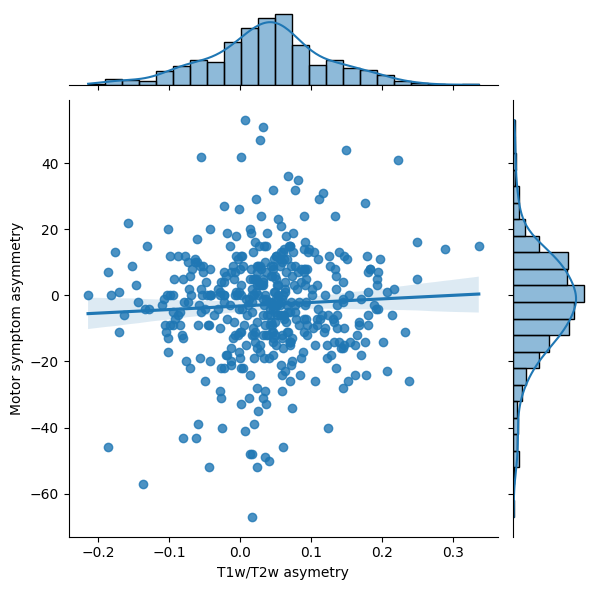

In [ ]:
import seaborn as sns

# Jointplot entre putamen_asymetry et df_msa_filtered['asymetry']
import matplotlib.pyplot as plt

# S'assurer que les index sont alignés
x_joint = putamen_asymetry.loc[df_msa_filtered.index]
y_joint = df_msa_filtered['asymetry']

# Retirer les valeurs manquantes
mask = ~x_joint.isna() & ~y_joint.isna()
x_joint_clean = x_joint[mask]
y_joint_clean = y_joint[mask]

# Afficher le jointplot
g = sns.jointplot(x=x_joint_clean, y=y_joint_clean, kind='reg')
g.set_axis_labels('T1w/T2w asymetry', 'Motor symptom asymmetry')
plt.show()